In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Define model & file name
model_name = 'LinearModel_Adjusted'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price_adj',
    'to_drop': 'sale_price',
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': None,
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class LinearModel_Adjusted(nn.Module):
    # Define model components
    def __init__(self):
        super().__init__()

        # Define linear model
        self.TextModel = nn.Linear(dataset.X_text.shape[1], 1)

    # Define forward pass
    def forward(self, X_text):
        y = self.TextModel(X_text)
        return y

In [11]:
# Instantiate model
model = LinearModel_Adjusted().to(device)

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 26


In [13]:
# Do not train if already trained
if Path(f'../models/{model_name}/state_dict.pt').is_file() and Path(f'../models/{model_name}/history.csv').is_file():
    # Load optimal weights and history
    model.load_state_dict(torch.load(f'../models/{model_name}/state_dict.pt'))
    history = pd.read_csv(f'../models/{model_name}/history.csv', index_col=0)
    print('Skipping training and loading optimal weights from previous training!')
else:
    # Train model
    model, history = sf.train_model(
        model=model,
        dataset_train=subsets['train'],
        dataset_val=subsets['val'],

        # Define loss & optimizer
        loss_function=nn.MSELoss().to(device),
        optimizer=torch.optim.SGD(model.parameters(), lr=.0001),

        # Define computing device
        device=device,

        # Define training parameters
        epochs=100,
        patience=100,
        delta=0,
        batch_size=64,
        shuffle=True,
        num_workers=0,
        pin_memory=True,

        # Define save locations
        save_state_dict_as=f'../models/{model_name}/state_dict.pt',
        save_history_as=f'../models/{model_name}/history.csv'
        )

100%|██████████| 646/646 [00:00<00:00, 3564.63it/s]


Epoch   1/100: RMSE_train: 1,604,776, RMSE_val: 1,548,928


100%|██████████| 646/646 [00:00<00:00, 4440.29it/s]


Epoch   2/100: RMSE_train: 1,504,784, RMSE_val: 1,451,910


100%|██████████| 646/646 [00:00<00:00, 4473.31it/s]


Epoch   3/100: RMSE_train: 1,429,156, RMSE_val: 1,394,361


100%|██████████| 646/646 [00:00<00:00, 4463.39it/s]


Epoch   4/100: RMSE_train: 1,368,819, RMSE_val: 1,336,795


100%|██████████| 646/646 [00:00<00:00, 4508.97it/s]


Epoch   5/100: RMSE_train: 1,320,443, RMSE_val: 1,308,395


100%|██████████| 646/646 [00:00<00:00, 4449.55it/s]


Epoch   6/100: RMSE_train: 1,281,671, RMSE_val: 1,285,427


100%|██████████| 646/646 [00:00<00:00, 4116.43it/s]


Epoch   7/100: RMSE_train: 1,250,980, RMSE_val: 1,263,206


100%|██████████| 646/646 [00:00<00:00, 4268.76it/s]


Epoch   8/100: RMSE_train: 1,226,341, RMSE_val: 1,255,544


100%|██████████| 646/646 [00:00<00:00, 4430.37it/s]


Epoch   9/100: RMSE_train: 1,206,825, RMSE_val: 1,247,278


100%|██████████| 646/646 [00:00<00:00, 4395.82it/s]


Epoch  10/100: RMSE_train: 1,191,557, RMSE_val: 1,243,914


100%|██████████| 646/646 [00:00<00:00, 4456.65it/s]


Epoch  11/100: RMSE_train: 1,179,457, RMSE_val: 1,247,155
EarlyStopping counter: 1 out of 100


100%|██████████| 646/646 [00:00<00:00, 4441.63it/s]


Epoch  12/100: RMSE_train: 1,169,943, RMSE_val: 1,248,722
EarlyStopping counter: 2 out of 100


100%|██████████| 646/646 [00:00<00:00, 4400.45it/s]


Epoch  13/100: RMSE_train: 1,162,552, RMSE_val: 1,253,362
EarlyStopping counter: 3 out of 100


100%|██████████| 646/646 [00:00<00:00, 4374.83it/s]


Epoch  14/100: RMSE_train: 1,156,609, RMSE_val: 1,261,983
EarlyStopping counter: 4 out of 100


100%|██████████| 646/646 [00:00<00:00, 4202.90it/s]


Epoch  15/100: RMSE_train: 1,151,932, RMSE_val: 1,265,092
EarlyStopping counter: 5 out of 100


100%|██████████| 646/646 [00:00<00:00, 4582.05it/s]


Epoch  16/100: RMSE_train: 1,148,456, RMSE_val: 1,279,963
EarlyStopping counter: 6 out of 100


100%|██████████| 646/646 [00:00<00:00, 4387.54it/s]


Epoch  17/100: RMSE_train: 1,145,504, RMSE_val: 1,281,121
EarlyStopping counter: 7 out of 100


100%|██████████| 646/646 [00:00<00:00, 4274.98it/s]


Epoch  18/100: RMSE_train: 1,143,156, RMSE_val: 1,297,959
EarlyStopping counter: 8 out of 100


100%|██████████| 646/646 [00:00<00:00, 4328.33it/s]


Epoch  19/100: RMSE_train: 1,141,267, RMSE_val: 1,298,613
EarlyStopping counter: 9 out of 100


100%|██████████| 646/646 [00:00<00:00, 3953.24it/s]


Epoch  20/100: RMSE_train: 1,139,796, RMSE_val: 1,308,728
EarlyStopping counter: 10 out of 100


100%|██████████| 646/646 [00:00<00:00, 4192.42it/s]


Epoch  21/100: RMSE_train: 1,138,681, RMSE_val: 1,321,240
EarlyStopping counter: 11 out of 100


100%|██████████| 646/646 [00:00<00:00, 4470.53it/s]


Epoch  22/100: RMSE_train: 1,137,702, RMSE_val: 1,327,177
EarlyStopping counter: 12 out of 100


100%|██████████| 646/646 [00:00<00:00, 4506.01it/s]


Epoch  23/100: RMSE_train: 1,136,845, RMSE_val: 1,337,477
EarlyStopping counter: 13 out of 100


100%|██████████| 646/646 [00:00<00:00, 4479.80it/s]


Epoch  24/100: RMSE_train: 1,136,232, RMSE_val: 1,345,667
EarlyStopping counter: 14 out of 100


100%|██████████| 646/646 [00:00<00:00, 4445.88it/s]


Epoch  25/100: RMSE_train: 1,135,642, RMSE_val: 1,360,602
EarlyStopping counter: 15 out of 100


100%|██████████| 646/646 [00:00<00:00, 4468.55it/s]


Epoch  26/100: RMSE_train: 1,135,285, RMSE_val: 1,364,793
EarlyStopping counter: 16 out of 100


100%|██████████| 646/646 [00:00<00:00, 4354.43it/s]


Epoch  27/100: RMSE_train: 1,134,738, RMSE_val: 1,371,870
EarlyStopping counter: 17 out of 100


100%|██████████| 646/646 [00:00<00:00, 4392.55it/s]


Epoch  28/100: RMSE_train: 1,134,551, RMSE_val: 1,380,887
EarlyStopping counter: 18 out of 100


100%|██████████| 646/646 [00:00<00:00, 4427.69it/s]


Epoch  29/100: RMSE_train: 1,134,077, RMSE_val: 1,393,103
EarlyStopping counter: 19 out of 100


100%|██████████| 646/646 [00:00<00:00, 4554.52it/s]


Epoch  30/100: RMSE_train: 1,133,949, RMSE_val: 1,399,015
EarlyStopping counter: 20 out of 100


100%|██████████| 646/646 [00:00<00:00, 4388.53it/s]


Epoch  31/100: RMSE_train: 1,133,638, RMSE_val: 1,407,017
EarlyStopping counter: 21 out of 100


100%|██████████| 646/646 [00:00<00:00, 4454.56it/s]


Epoch  32/100: RMSE_train: 1,133,555, RMSE_val: 1,414,764
EarlyStopping counter: 22 out of 100


100%|██████████| 646/646 [00:00<00:00, 4381.30it/s]


Epoch  33/100: RMSE_train: 1,133,397, RMSE_val: 1,436,950
EarlyStopping counter: 23 out of 100


100%|██████████| 646/646 [00:00<00:00, 4508.85it/s]


Epoch  34/100: RMSE_train: 1,133,080, RMSE_val: 1,438,822
EarlyStopping counter: 24 out of 100


100%|██████████| 646/646 [00:00<00:00, 4576.31it/s]


Epoch  35/100: RMSE_train: 1,133,033, RMSE_val: 1,441,611
EarlyStopping counter: 25 out of 100


100%|██████████| 646/646 [00:00<00:00, 4440.69it/s]


Epoch  36/100: RMSE_train: 1,132,764, RMSE_val: 1,447,083
EarlyStopping counter: 26 out of 100


100%|██████████| 646/646 [00:00<00:00, 4281.49it/s]


Epoch  37/100: RMSE_train: 1,132,631, RMSE_val: 1,456,469
EarlyStopping counter: 27 out of 100


100%|██████████| 646/646 [00:00<00:00, 4548.34it/s]


Epoch  38/100: RMSE_train: 1,132,509, RMSE_val: 1,468,441
EarlyStopping counter: 28 out of 100


100%|██████████| 646/646 [00:00<00:00, 4477.87it/s]


Epoch  39/100: RMSE_train: 1,132,335, RMSE_val: 1,470,199
EarlyStopping counter: 29 out of 100


100%|██████████| 646/646 [00:00<00:00, 4411.54it/s]


Epoch  40/100: RMSE_train: 1,132,302, RMSE_val: 1,479,268
EarlyStopping counter: 30 out of 100


100%|██████████| 646/646 [00:00<00:00, 4401.35it/s]


Epoch  41/100: RMSE_train: 1,132,130, RMSE_val: 1,484,845
EarlyStopping counter: 31 out of 100


100%|██████████| 646/646 [00:00<00:00, 4367.88it/s]


Epoch  42/100: RMSE_train: 1,131,982, RMSE_val: 1,491,754
EarlyStopping counter: 32 out of 100


100%|██████████| 646/646 [00:00<00:00, 4444.93it/s]


Epoch  43/100: RMSE_train: 1,131,937, RMSE_val: 1,500,163
EarlyStopping counter: 33 out of 100


100%|██████████| 646/646 [00:00<00:00, 4588.75it/s]


Epoch  44/100: RMSE_train: 1,131,868, RMSE_val: 1,506,229
EarlyStopping counter: 34 out of 100


100%|██████████| 646/646 [00:00<00:00, 4540.45it/s]


Epoch  45/100: RMSE_train: 1,131,751, RMSE_val: 1,511,843
EarlyStopping counter: 35 out of 100


100%|██████████| 646/646 [00:00<00:00, 4528.15it/s]


Epoch  46/100: RMSE_train: 1,131,733, RMSE_val: 1,524,726
EarlyStopping counter: 36 out of 100


100%|██████████| 646/646 [00:00<00:00, 4357.12it/s]


Epoch  47/100: RMSE_train: 1,131,517, RMSE_val: 1,532,745
EarlyStopping counter: 37 out of 100


100%|██████████| 646/646 [00:00<00:00, 4388.89it/s]


Epoch  48/100: RMSE_train: 1,131,406, RMSE_val: 1,532,252
EarlyStopping counter: 38 out of 100


100%|██████████| 646/646 [00:00<00:00, 4653.21it/s]


Epoch  49/100: RMSE_train: 1,131,324, RMSE_val: 1,537,357
EarlyStopping counter: 39 out of 100


100%|██████████| 646/646 [00:00<00:00, 4664.12it/s]


Epoch  50/100: RMSE_train: 1,131,346, RMSE_val: 1,546,869
EarlyStopping counter: 40 out of 100


100%|██████████| 646/646 [00:00<00:00, 4468.71it/s]


Epoch  51/100: RMSE_train: 1,131,316, RMSE_val: 1,550,700
EarlyStopping counter: 41 out of 100


100%|██████████| 646/646 [00:00<00:00, 4361.39it/s]


Epoch  52/100: RMSE_train: 1,131,242, RMSE_val: 1,554,645
EarlyStopping counter: 42 out of 100


100%|██████████| 646/646 [00:00<00:00, 4409.95it/s]


Epoch  53/100: RMSE_train: 1,131,215, RMSE_val: 1,562,115
EarlyStopping counter: 43 out of 100


100%|██████████| 646/646 [00:00<00:00, 4472.48it/s]


Epoch  54/100: RMSE_train: 1,131,131, RMSE_val: 1,565,137
EarlyStopping counter: 44 out of 100


100%|██████████| 646/646 [00:00<00:00, 4616.04it/s]


Epoch  55/100: RMSE_train: 1,130,976, RMSE_val: 1,570,700
EarlyStopping counter: 45 out of 100


100%|██████████| 646/646 [00:00<00:00, 4387.37it/s]


Epoch  56/100: RMSE_train: 1,130,866, RMSE_val: 1,590,161
EarlyStopping counter: 46 out of 100


100%|██████████| 646/646 [00:00<00:00, 4443.16it/s]


Epoch  57/100: RMSE_train: 1,130,982, RMSE_val: 1,580,070
EarlyStopping counter: 47 out of 100


100%|██████████| 646/646 [00:00<00:00, 4447.63it/s]


Epoch  58/100: RMSE_train: 1,130,846, RMSE_val: 1,585,303
EarlyStopping counter: 48 out of 100


100%|██████████| 646/646 [00:00<00:00, 4403.96it/s]


Epoch  59/100: RMSE_train: 1,130,685, RMSE_val: 1,593,513
EarlyStopping counter: 49 out of 100


100%|██████████| 646/646 [00:00<00:00, 4484.83it/s]


Epoch  60/100: RMSE_train: 1,130,736, RMSE_val: 1,600,736
EarlyStopping counter: 50 out of 100


100%|██████████| 646/646 [00:00<00:00, 4503.60it/s]


Epoch  61/100: RMSE_train: 1,130,700, RMSE_val: 1,599,198
EarlyStopping counter: 51 out of 100


100%|██████████| 646/646 [00:00<00:00, 4477.96it/s]


Epoch  62/100: RMSE_train: 1,130,814, RMSE_val: 1,605,477
EarlyStopping counter: 52 out of 100


100%|██████████| 646/646 [00:00<00:00, 4522.57it/s]


Epoch  63/100: RMSE_train: 1,130,608, RMSE_val: 1,608,551
EarlyStopping counter: 53 out of 100


100%|██████████| 646/646 [00:00<00:00, 4195.70it/s]


Epoch  64/100: RMSE_train: 1,130,546, RMSE_val: 1,612,207
EarlyStopping counter: 54 out of 100


100%|██████████| 646/646 [00:00<00:00, 4683.30it/s]


Epoch  65/100: RMSE_train: 1,130,450, RMSE_val: 1,618,834
EarlyStopping counter: 55 out of 100


100%|██████████| 646/646 [00:00<00:00, 4508.08it/s]


Epoch  66/100: RMSE_train: 1,130,406, RMSE_val: 1,619,713
EarlyStopping counter: 56 out of 100


100%|██████████| 646/646 [00:00<00:00, 4448.74it/s]


Epoch  67/100: RMSE_train: 1,130,324, RMSE_val: 1,624,432
EarlyStopping counter: 57 out of 100


100%|██████████| 646/646 [00:00<00:00, 4600.82it/s]


Epoch  68/100: RMSE_train: 1,130,356, RMSE_val: 1,637,574
EarlyStopping counter: 58 out of 100


100%|██████████| 646/646 [00:00<00:00, 4441.78it/s]


Epoch  69/100: RMSE_train: 1,130,221, RMSE_val: 1,637,466
EarlyStopping counter: 59 out of 100


100%|██████████| 646/646 [00:00<00:00, 4577.67it/s]


Epoch  70/100: RMSE_train: 1,130,255, RMSE_val: 1,637,740
EarlyStopping counter: 60 out of 100


100%|██████████| 646/646 [00:00<00:00, 4411.66it/s]


Epoch  71/100: RMSE_train: 1,130,195, RMSE_val: 1,640,129
EarlyStopping counter: 61 out of 100


100%|██████████| 646/646 [00:00<00:00, 4592.28it/s]


Epoch  72/100: RMSE_train: 1,130,109, RMSE_val: 1,644,306
EarlyStopping counter: 62 out of 100


100%|██████████| 646/646 [00:00<00:00, 4613.39it/s]


Epoch  73/100: RMSE_train: 1,130,132, RMSE_val: 1,646,707
EarlyStopping counter: 63 out of 100


100%|██████████| 646/646 [00:00<00:00, 4455.05it/s]


Epoch  74/100: RMSE_train: 1,130,170, RMSE_val: 1,652,401
EarlyStopping counter: 64 out of 100


100%|██████████| 646/646 [00:00<00:00, 4588.85it/s]


Epoch  75/100: RMSE_train: 1,130,092, RMSE_val: 1,655,449
EarlyStopping counter: 65 out of 100


100%|██████████| 646/646 [00:00<00:00, 4595.90it/s]


Epoch  76/100: RMSE_train: 1,130,030, RMSE_val: 1,660,060
EarlyStopping counter: 66 out of 100


100%|██████████| 646/646 [00:00<00:00, 4543.25it/s]


Epoch  77/100: RMSE_train: 1,130,021, RMSE_val: 1,662,956
EarlyStopping counter: 67 out of 100


100%|██████████| 646/646 [00:00<00:00, 4549.23it/s]


Epoch  78/100: RMSE_train: 1,129,989, RMSE_val: 1,669,403
EarlyStopping counter: 68 out of 100


100%|██████████| 646/646 [00:00<00:00, 4479.80it/s]


Epoch  79/100: RMSE_train: 1,129,945, RMSE_val: 1,665,781
EarlyStopping counter: 69 out of 100


100%|██████████| 646/646 [00:00<00:00, 4541.59it/s]


Epoch  80/100: RMSE_train: 1,129,985, RMSE_val: 1,670,251
EarlyStopping counter: 70 out of 100


100%|██████████| 646/646 [00:00<00:00, 4523.81it/s]


Epoch  81/100: RMSE_train: 1,130,088, RMSE_val: 1,674,647
EarlyStopping counter: 71 out of 100


100%|██████████| 646/646 [00:00<00:00, 4020.23it/s]


Epoch  82/100: RMSE_train: 1,130,109, RMSE_val: 1,674,080
EarlyStopping counter: 72 out of 100


100%|██████████| 646/646 [00:00<00:00, 4216.57it/s]


Epoch  83/100: RMSE_train: 1,129,785, RMSE_val: 1,676,398
EarlyStopping counter: 73 out of 100


100%|██████████| 646/646 [00:00<00:00, 4383.20it/s]


Epoch  84/100: RMSE_train: 1,129,883, RMSE_val: 1,678,798
EarlyStopping counter: 74 out of 100


100%|██████████| 646/646 [00:00<00:00, 4570.15it/s]


Epoch  85/100: RMSE_train: 1,129,908, RMSE_val: 1,683,115
EarlyStopping counter: 75 out of 100


100%|██████████| 646/646 [00:00<00:00, 4516.00it/s]


Epoch  86/100: RMSE_train: 1,129,860, RMSE_val: 1,685,550
EarlyStopping counter: 76 out of 100


100%|██████████| 646/646 [00:00<00:00, 4354.40it/s]


Epoch  87/100: RMSE_train: 1,129,710, RMSE_val: 1,686,626
EarlyStopping counter: 77 out of 100


100%|██████████| 646/646 [00:00<00:00, 4307.44it/s]


Epoch  88/100: RMSE_train: 1,129,693, RMSE_val: 1,694,090
EarlyStopping counter: 78 out of 100


100%|██████████| 646/646 [00:00<00:00, 4238.52it/s]


Epoch  89/100: RMSE_train: 1,129,634, RMSE_val: 1,695,126
EarlyStopping counter: 79 out of 100


100%|██████████| 646/646 [00:00<00:00, 4353.69it/s]


Epoch  90/100: RMSE_train: 1,129,685, RMSE_val: 1,698,083
EarlyStopping counter: 80 out of 100


100%|██████████| 646/646 [00:00<00:00, 4405.38it/s]


Epoch  91/100: RMSE_train: 1,129,581, RMSE_val: 1,696,009
EarlyStopping counter: 81 out of 100


100%|██████████| 646/646 [00:00<00:00, 4401.33it/s]


Epoch  92/100: RMSE_train: 1,129,612, RMSE_val: 1,698,286
EarlyStopping counter: 82 out of 100


100%|██████████| 646/646 [00:00<00:00, 4623.14it/s]


Epoch  93/100: RMSE_train: 1,129,700, RMSE_val: 1,704,110
EarlyStopping counter: 83 out of 100


100%|██████████| 646/646 [00:00<00:00, 4378.46it/s]


Epoch  94/100: RMSE_train: 1,129,554, RMSE_val: 1,702,425
EarlyStopping counter: 84 out of 100


100%|██████████| 646/646 [00:00<00:00, 4472.42it/s]


Epoch  95/100: RMSE_train: 1,129,702, RMSE_val: 1,708,335
EarlyStopping counter: 85 out of 100


100%|██████████| 646/646 [00:00<00:00, 4544.69it/s]


Epoch  96/100: RMSE_train: 1,129,677, RMSE_val: 1,707,637
EarlyStopping counter: 86 out of 100


100%|██████████| 646/646 [00:00<00:00, 4560.89it/s]


Epoch  97/100: RMSE_train: 1,129,437, RMSE_val: 1,708,948
EarlyStopping counter: 87 out of 100


100%|██████████| 646/646 [00:00<00:00, 4523.44it/s]


Epoch  98/100: RMSE_train: 1,129,435, RMSE_val: 1,710,125
EarlyStopping counter: 88 out of 100


100%|██████████| 646/646 [00:00<00:00, 4443.77it/s]


Epoch  99/100: RMSE_train: 1,129,410, RMSE_val: 1,712,155
EarlyStopping counter: 89 out of 100


100%|██████████| 646/646 [00:00<00:00, 4446.95it/s]

Epoch 100/100: RMSE_train: 1,129,430, RMSE_val: 1,713,106
EarlyStopping counter: 90 out of 100


In [14]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, device, save_as=f'../models/{model_name}/predictions.csv')

100%|██████████| 59046/59046 [00:01<00:00, 42352.05it/s]


In [15]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1185005.483  675005.967  0.866   0.026
val     1247847.531  667699.229  0.905  -0.096
test    1177688.724  665267.071  0.839   0.033
----------------------------------------------
total   1189986.383  672327.621  0.864   0.016


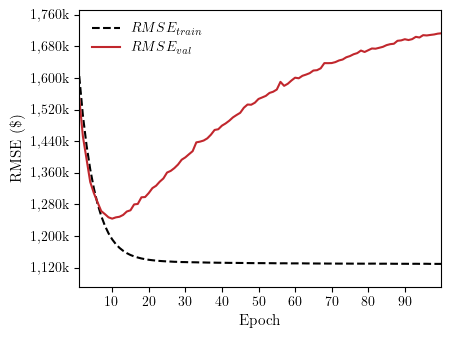

In [16]:
# Plot training history
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

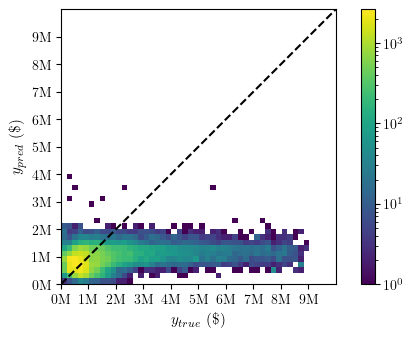

In [17]:
# Plot predictions vs actuals
sf.plot_pred_vs_actual(predictions, save_as=f'../models/{model_name}/predictions_vs_actuals.pdf')